In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

2025-07-16 11:33:36.409354: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 11:33:36.625706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752644916.751111     488 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752644916.800531     488 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-16 11:33:37.032124: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Since size of dataset is too larger(500K) reducing it to 18K only

In [5]:
import os, random, shutil

src_dir = f'/home/harry/Documents/Code/Data_Science/DeepLearning/CNN_projects/Hagrid_Classification/datasets/hagrid-classification-512p-no-gesture-150k'
dst_dir = f'/home/harry/Documents/Code/Data_Science/DeepLearning/CNN_projects/Hagrid_Classification/datasets/hagrid-classification-small'
sample_per_class = 50  # adjust as needed

for class_name in os.listdir(src_dir):
    class_path = os.path.join(src_dir, class_name)
    images = os.listdir(class_path)
    sampled = random.sample(images, sample_per_class)
    os.makedirs(os.path.join(dst_dir, class_name), exist_ok=True)
    for img in sampled:
        shutil.copy(os.path.join(class_path, img), os.path.join(dst_dir, class_name, img))


In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
EPOCHS  = 50
CHANNELS = 3


In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                                    dst_dir, # Path to your datasets
                                                    shuffle = True,
                                                    image_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size = BATCH_SIZE)

Found 800 files belonging to 8 classes.


2025-07-16 11:33:43.935955: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
class_names = dataset.class_names
class_names

['four', 'like', 'mute', 'ok', 'peace', 'rock', 'stop', 'three']

(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)


2025-07-16 11:40:27.451149: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


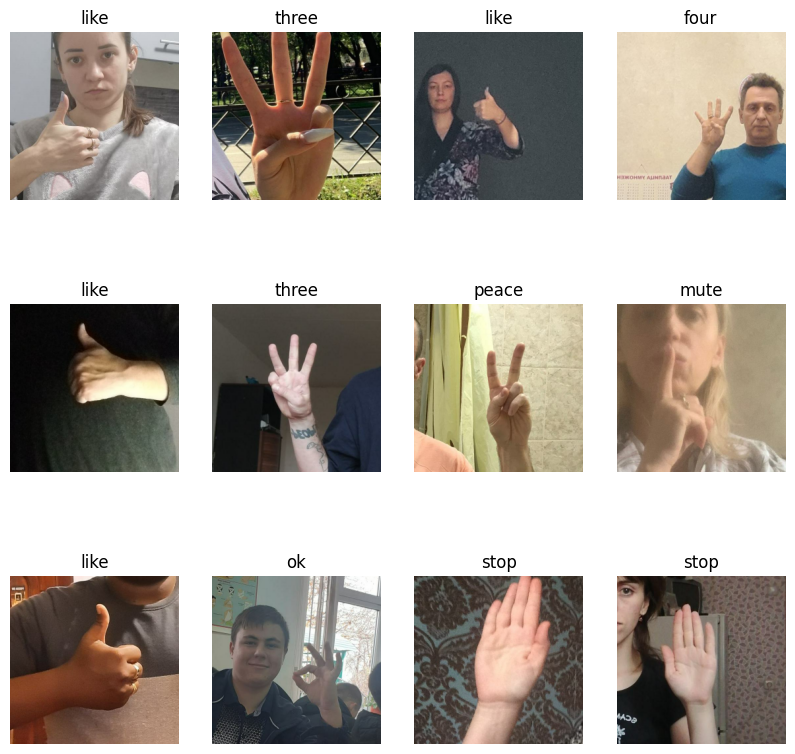

In [23]:

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        print(image_batch.shape)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [24]:
# Spliting the dataset into train,validation and test
def get_dataset_partitions_tf(ds , train_split=0.8,val_split=0.1,test_split = 0.1,shuffle = True ,shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        df = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [25]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [26]:
# Using cache() and prefetch() this will imporve loading time
train_ds = train_ds.shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size = tf.data.AUTOTUNE)



In [27]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])


In [28]:
n_classes = len(class_names)
base_model = tf.keras.applications.MobileNet(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Start with frozen base
model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])


/tmp/ipykernel_488/1452161247.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(


In [29]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 8, 8, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,361,096 (12.82 MB)

 Trainable params: 132,232 (516.53 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [38]:

model.compile(
    optimizer='RMSprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [39]:

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Learning rate scheduler: reduce LR if val_loss doesn't improve for 3 epochs
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Early stopping: stop training if val_loss doesn't improve for 6 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

In [40]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose= 1,
    validation_data=val_ds,
   # callbacks=[lr_scheduler, early_stop]

)




Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 662ms/step - accuracy: 0.1306 - loss: 2.6877 - val_accuracy: 0.2875 - val_loss: 1.8985
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 652ms/step - accuracy: 0.1902 - loss: 1.9917 - val_accuracy: 0.4000 - val_loss: 1.6814
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 697ms/step - accuracy: 0.3529 - loss: 1.8082 - val_accuracy: 0.3375 - val_loss: 1.6371
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 660ms/step - accuracy: 0.4544 - loss: 1.5889 - val_accuracy: 0.5250 - val_loss: 1.3929
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 655ms/step - accuracy: 0.4054 - loss: 1.5320 - val_accuracy: 0.4500 - val_loss: 1.4111
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 639ms/step - accuracy: 0.4267 - loss: 1.4509 - val_accuracy: 0.4875 - val_loss: 1.3873
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 651ms/step - accuracy: 0.5153 - loss: 1.3606 - val_accuracy: 0.5625 - val_loss: 1.1865
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 700ms/step - accuracy: 0.5415 - loss: 1.3085 - val_accu

In [41]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 40}

In [42]:
history.params.keys()

dict_keys(['verbose', 'epochs', 'steps'])

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Traning and Validation Accuracy')

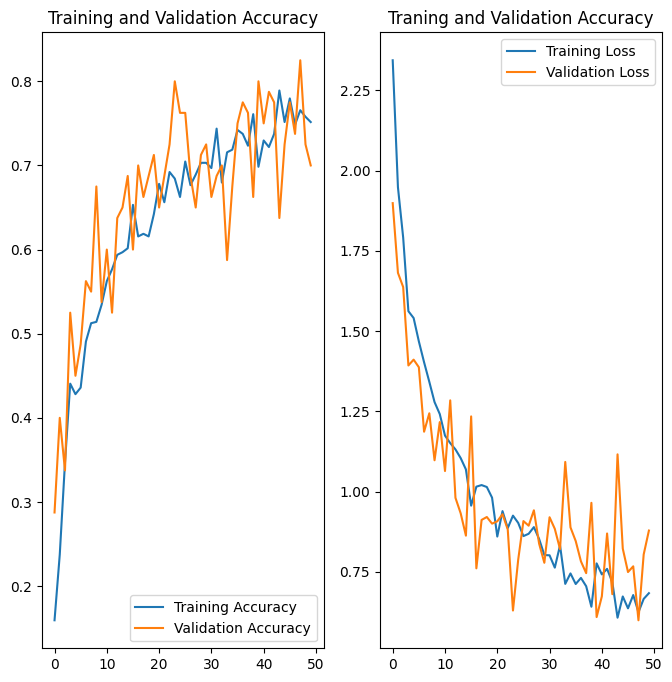

In [44]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc , label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
plt.legend(loc ='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss , label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title("Traning and Validation Accuracy")

first image to predict
first image actual label: three
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Label: three


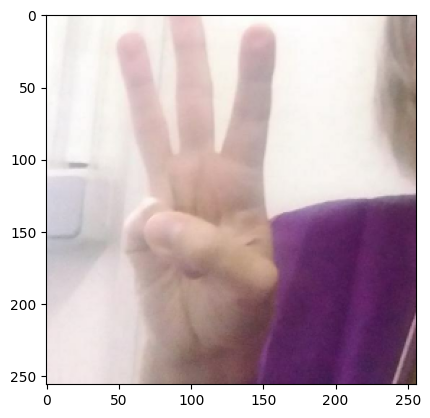

In [45]:
for images_batch,labels_batch in test_ds.take(1):
    first_image = (images_batch[0].numpy().astype('uint8'))
    first_label = labels_batch[0]

    print('first image to predict')
    plt.imshow(first_image)
    print('first image actual label:',class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print('Predicted Label:',class_names[np.argmax(batch_prediction[0])])


In [46]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


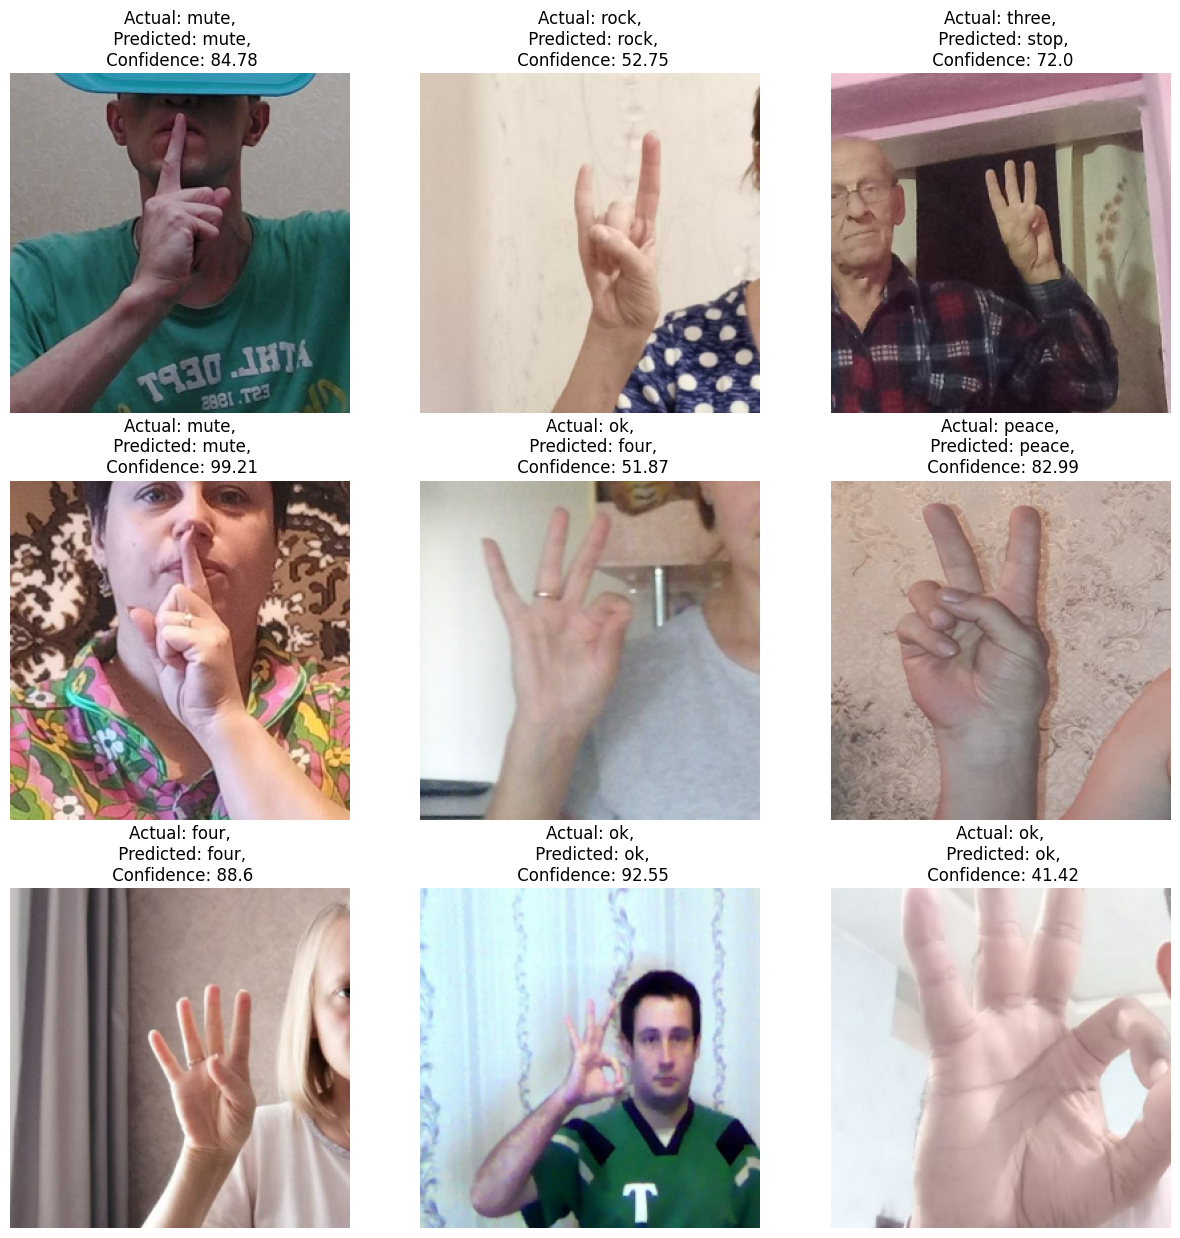

In [47]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidense = predict(model,images[i].numpy())

        actual_class = class_names[labels[i]]

        plt.title(f"Actual: { actual_class},\n Predicted: {predicted_class},\n Confidence: {confidense}")

        plt.axis('off')